# Youtube Channel Analysis

### Import necessary libraries.

In [27]:
import pandas as pd
from pandas import DataFrame as df
from googleapiclient.discovery import build
import seaborn as sns
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import emoji
import nltk
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter 
import re


### Get Channel ID

In [28]:
# Load the api key from .env file
load_dotenv()
# Access the API key from .env file
api_key = os.getenv("API_KEY")

# To get channel id, go to view page source, search channel/ and find the Channel ID from there

channel_id = 'UC-B1DgLsZVCsmn86m3diX3w'   # THE CASETOO'S 
# Got credentials and create an API Client object
api_service_name = 'youtube'
api_version = 'v3'

youtube = build(api_service_name, api_version, developerKey=api_key)


### Extract Channel Details

In [29]:
# For a single Channel
# Function to get channel statistics for a given channel
# channel_id = 'UCgZK0B5z3A2m5UWYvPpZcHw'                           # Casetoo Channel ID
def get_channel_stats(youtube, channel_id):
    # def get_channel_stats(youtube, channel_ids):
    requests = youtube.channels().list(
        part = 'snippet,contentDetails, statistics',
        id = channel_id
    )
    response = requests.execute()
    data = dict(Channel_Name = response['items'][0]['snippet']['title'],
                #Channel_Creation = response['items'][0]['snippet']['publishedAt'],
                Total_Views = response['items'][0]['statistics']['viewCount'],
                Total_Subscribers = response['items'][0]['statistics']['subscriberCount'],
                Total_Videos = response['items'][0]['statistics']['videoCount'],
                PlayList_Id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
                )

    return data
channel_statisctics = get_channel_stats(youtube, channel_id)

In [30]:
channel_statisctics
channel_data = pd.DataFrame([channel_statisctics])

In [31]:
channel_data

,Channel_Name,Total_Views,Total_Subscribers,Total_Videos,PlayList_Id
0,THE CASETOO,159305183,434000,924,UU-B1DgLsZVCsmn86m3diX3w


In [32]:
# Convert the data types of column total_views, total_subscribers and total_videos  to integer and rest to text
channel_data['Total_Views'] = pd.to_numeric(channel_data['Total_Views'])
channel_data['Total_Subscribers'] = pd.to_numeric(channel_data['Total_Subscribers'])
channel_data['Total_Videos'] = pd.to_numeric(channel_data['Total_Videos'])
channel_data.dtypes

Channel_Name         object
Total_Views           int64
Total_Subscribers     int64
Total_Videos          int64
PlayList_Id          object
dtype: object

## Let's Do some EDA 

In [33]:
PlayList_Id = channel_data.loc[channel_data["Channel_Name"] == "THE CASETOO", 'PlayList_Id'].iloc[0]
PlayList_Id

'UU-B1DgLsZVCsmn86m3diX3w'

In [34]:
# Function to fetch the video ID
# By default, it will return only 50 results.

def get_video_ids(youtube, PlayList_Id):
    request = youtube.playlistItems().list(
                part = 'contentDetails' ,
                playlistId = PlayList_Id,
                maxResults = 50,                # To get more results than the default i.e 50
            )
    response = request.execute()

    video_ids = []  # list of video ids
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    # Dictionary will throw error if nextPageToken is not present, hence here we use get() method
    more_pages = True

    while more_pages:
        if next_page_token is None:
            # No more pages to get, break the loop
            print("No more pages to get")
            print("Total Video ID's : ",len(video_ids))
            # print(video_ids)
            break
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part = 'contentDetails',
                playlistId = PlayList_Id,
                maxResults = 50,
                pageToken = next_page_token
            )
            response = request.execute()
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            # Change next page token     
            next_page_token = response.get('nextPageToken')
    # return len(video_ids)    ## To check the length of the list
    
    return video_ids
# Save the result to a variable video_ids for later use
video_ids = get_video_ids(youtube,PlayList_Id)


No more pages to get
Total Video ID's :  924


Now Let's extract details from Video ID's

In [35]:
def get_video_details(youtube, video_ids):
    request  = youtube.videos().list(
        part = 'snippet, statistics',
        id = ','.join(video_ids[:50])
    )
    response = request.execute()
    return response      
get_video_details(youtube, video_ids)

{'kind': 'youtube#videoListResponse',
 'etag': '83QTxoXxwZJ790rEcfiz6c76LEA',
 'items': [{'kind': 'youtube#video',
   'etag': 'HtdMenhqakUcnTUl9Q_RvfUqAhA',
   'id': '3Vyi0UrbKv4',
   'snippet': {'publishedAt': '2023-08-14T12:31:54Z',
    'channelId': 'UC-B1DgLsZVCsmn86m3diX3w',
    'title': '836.536% People Take 2 Years To Complete This IMPOSSIBLE Race in GTA 5!',
    'description': '🔥 Instagram - https://Instagram.com/casetooyt\n\nEmail - mailcasetoo@gmail.com',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/3Vyi0UrbKv4/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/3Vyi0UrbKv4/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/3Vyi0UrbKv4/hqdefault.jpg',
      'width': 480,
      'height': 360},
     'standard': {'url': 'https://i.ytimg.com/vi/3Vyi0UrbKv4/sddefault.jpg',
      'width': 640,
      'height': 480},
     'maxres': {'url': 'https://i.ytimg.com/vi/3Vyi

In [36]:
def get_video_stats(youtube, video_ids):
    videos_data = []
    for i in range(0, len(video_ids), 50):
        requests = youtube.videos().list(
            part = 'snippet, statistics',
            id = ','.join(video_ids[i:i+50])
        )
        response = requests.execute()

        for video in response['items']:
            video_stats = dict(
                Video_Title = video['snippet']['title'],
                Video_Description = video['snippet']['description'],
                Video_Tags = video['snippet']['tags'],
                Video_Views = video['statistics']['viewCount'],
                Video_Likes = video['statistics']['likeCount'],
                Video_Comments = video['statistics']['commentCount'],
                Video_Published_Date = video['snippet']['publishedAt'],
                Video_ID = video['id'],
                #Video_Comments_Text = video['snippet']['topLevelComment']['snippet']['textDisplay'],
                #Video_Duration = video['contentDetails']['duration']
            )
            videos_data.append(video_stats)
    return videos_data

video_statistics = get_video_stats(youtube, video_ids)
video_data = pd.DataFrame(video_statistics)   # Save the data to a DataFrame
print(video_data)


# # Check data types of each column
# print(video_data.dtypes)

                                           Video_Title  \
0    836.536% People Take 2 Years To Complete This ...   
1    When You Pop 100,00,000 Balloons in 1 Minute -...   
2    Car vs Car 655.556% People Get Brain Damage Af...   
3    I Built My House in The Mountain - Mountain Li...   
4    474.747% People Get Lost in This Pipe Parkour ...   
..                                                 ...   
919          I Became A HACKER in Roblox BODYBUILDING!   
920  Upgrading From NOOB To HACKER in Roblox BODYBU...   
921       TRYING To KILL The GUARD in PRISON in ROBLOX   
922      98% FAIL IN THIS MINECRAFT PARKOUR CHALLENGE!   
923                      ROBLOX SQUID GAME IS TOO EAZY   

                                     Video_Description  \
0    🔥 Instagram - https://Instagram.com/casetooyt\...   
1    🔥 Instagram - https://Instagram.com/casetooyt\...   
2    🔥 Instagram - https://Instagram.com/casetooyt\...   
3    🔥 Instagram - https://Instagram.com/casetooyt\...   
4    🔥 Instag

#### Let's do some Data Cleaning

##### Change Data Types 

In [37]:
# Convert the data type of Video_Views, Video_Likes, Video_Comments to numeric values
video_data['Video_Title'] = video_data['Video_Title'].apply(lambda x: x.replace("'", ""))
video_data['Video_Views'] = pd.to_numeric(video_data['Video_Views'], errors='coerce')
video_data['Video_Likes'] = pd.to_numeric(video_data['Video_Likes'], errors='coerce')
video_data['Video_Comments'] = pd.to_numeric(video_data['Video_Comments'], errors='coerce')
video_data['Video_Published_Date'] = pd.to_datetime(video_data['Video_Published_Date'], errors='coerce')
#video_data['Video_Duration'] = pd.to_datetime(video_data['Video_Duration'], errors='coerce')
video_data.dtypes

Video_Title                          object
Video_Description                    object
Video_Tags                           object
Video_Views                           int64
Video_Likes                           int64
Video_Comments                        int64
Video_Published_Date    datetime64[ns, UTC]
Video_ID                             object
dtype: object

##### Modify the Video Published Date so that it only shows Year

In [38]:
video_data['Video_Published_Date'] = pd.to_datetime(video_data['Video_Published_Date'], errors='coerce').dt.date
video_data

,Video_Title,Video_Description,Video_Tags,Video_Views,Video_Likes,Video_Comments,Video_Published_Date,Video_ID
0,836.536% People Take 2 Years To Complete This ...,🔥 Instagram - https://Instagram.com/casetooyt\...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",19667,3953,240,2023-08-14,3Vyi0UrbKv4
1,"When You Pop 100,00,000 Balloons in 1 Minute -...",🔥 Instagram - https://Instagram.com/casetooyt\...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",22679,2618,161,2023-08-14,2fXwyKiJXo8
2,Car vs Car 655.556% People Get Brain Damage Af...,🔥 Instagram - https://Instagram.com/casetooyt\...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",103788,9019,359,2023-08-13,MN1Es5mj6zU
3,I Built My House in The Mountain - Mountain Li...,🔥 Instagram - https://Instagram.com/casetooyt\...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",33829,3401,295,2023-08-13,IJs7eRp4kF4
4,474.747% People Get Lost in This Pipe Parkour ...,🔥 Instagram - https://Instagram.com/casetooyt\...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",115667,10088,277,2023-08-12,R0Rre9hGcaE
...,...,...,...,...,...,...,...,...
919,I Became A HACKER in Roblox BODYBUILDING!,Official Instagram - https://Instagram.com/cas...,"[Roblox, gta, gta 5, gta 5 gameplay, gta 5 fun...",69422,7202,226,2021-10-29,bFJnXMJiCqQ
920,Upgrading From NOOB To HACKER in Roblox BODYBU...,Official Instagram - https://Instagram.com/cas...,"[Roblox, gta, gta 5, gta 5 gameplay, gta 5 fun...",77045,7534,185,2021-10-27,m3UKqE8meyU
921,TRYING To KILL The GUARD in PRISON in ROBLOX,New Roblox Gameplay hindi\n\nOfficial Instagra...,"[Roblox, gta, gta 5, gta 5 gameplay, gta 5 fun...",37879,5517,119,2021-10-22,VGFfdirSCk0
922,98% FAIL IN THIS MINECRAFT PARKOUR CHALLENGE!,Official Instagram - https://Instagram.com/cas...,"[Roblox, gta, gta 5, gta 5 gameplay, gta 5 fun...",69078,9236,317,2021-10-19,teRWN2KdRPo


#### Let's remove Emoji's from Description 

In [39]:
# Function to remove emojis
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

# Let's remove the emojies from the titles since its gonna interfere with the plots.
video_data.Video_Description  = video_data.Video_Description.apply(remove_emoji)
video_data.head()



,Video_Title,Video_Description,Video_Tags,Video_Views,Video_Likes,Video_Comments,Video_Published_Date,Video_ID
0,836.536% People Take 2 Years To Complete This ...,Instagram - https://Instagram.com/casetooyt\n...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",19667,3953,240,2023-08-14,3Vyi0UrbKv4
1,"When You Pop 100,00,000 Balloons in 1 Minute -...",Instagram - https://Instagram.com/casetooyt\n...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",22679,2618,161,2023-08-14,2fXwyKiJXo8
2,Car vs Car 655.556% People Get Brain Damage Af...,Instagram - https://Instagram.com/casetooyt\n...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",103788,9019,359,2023-08-13,MN1Es5mj6zU
3,I Built My House in The Mountain - Mountain Li...,Instagram - https://Instagram.com/casetooyt\n...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",33829,3401,295,2023-08-13,IJs7eRp4kF4
4,474.747% People Get Lost in This Pipe Parkour ...,Instagram - https://Instagram.com/casetooyt\n...,"[gta, gta 5, gta 5 gameplay, gta 5 funny momen...",115667,10088,277,2023-08-12,R0Rre9hGcaE


##### Save the data into a csv file

In [40]:
# Save the DataFrame to a CSV file
video_data.to_csv('video_data.csv')

### Let's Do some ANALYSIS :))

##### Check for null values (Although, We are already aware that there are no null values)

In [41]:
# Check if there are any missing values in the dataset. 
def check_missing_values(df):
    return df.isnull().sum()

check_missing_values(video_data)


Video_Title             0
Video_Description       0
Video_Tags              0
Video_Views             0
Video_Likes             0
Video_Comments          0
Video_Published_Date    0
Video_ID                0
dtype: int64

##### Find the number of rows and columns in the dataset

In [42]:

def find_shape(df):
    return df.shape
find_shape(video_data)


(924, 8)

#### Basic Summary

In [43]:
df = pd.read_csv("video_data.csv")
# Calculate summary statistics
summary_stats = df[['Video_Views', 'Video_Likes', 'Video_Comments']].describe()
print(summary_stats)

        Video_Views   Video_Likes  Video_Comments
count  9.240000e+02    924.000000      924.000000
mean   1.725930e+05  13010.472944      441.597403
std    1.130243e+05   5989.541964      247.381906
min    1.966700e+04   2618.000000       38.000000
25%    9.673400e+04   7570.750000      270.000000
50%    1.624230e+05  13492.500000      394.000000
75%    2.098322e+05  16562.250000      550.250000
max    1.467132e+06  46773.000000     2226.000000


#### Most Viewed Video

In [44]:
# Video with maximum views
columns_of_interest = ['Video_Title', 'Video_Likes', 'Video_Comments','Video_Views', 'Video_ID']
max_views_video = video_data[video_data['Video_Views'] == video_data['Video_Views'].max()][columns_of_interest]

# Print the video(s) with maximum views and selected columns
print(max_views_video)

                                           Video_Title  Video_Likes  \
850  Cars Vs Cars 99.716% People Fall in Water in T...        46773   

     Video_Comments  Video_Views     Video_ID  
850             511      1467132  64OCJpl6QAc  


#### Least Viewed Video

In [45]:
# Video with minimum views
columns_of_interest = ['Video_Title', 'Video_Likes', 'Video_Comments','Video_Views', 'Video_ID']
min_views_video = video_data[video_data['Video_Views'] == video_data['Video_Views'].min()][columns_of_interest]

# Print the video(s) with maximum views and selected columns
print(min_views_video)

                                         Video_Title  Video_Likes  \
0  836.536% People Take 2 Years To Complete This ...         3953   

   Video_Comments  Video_Views     Video_ID  
0             240        19667  3Vyi0UrbKv4  


1. What is the overall trend in video views over time?

Solution: Create a line plot of views over the upload date to visualize the trend.

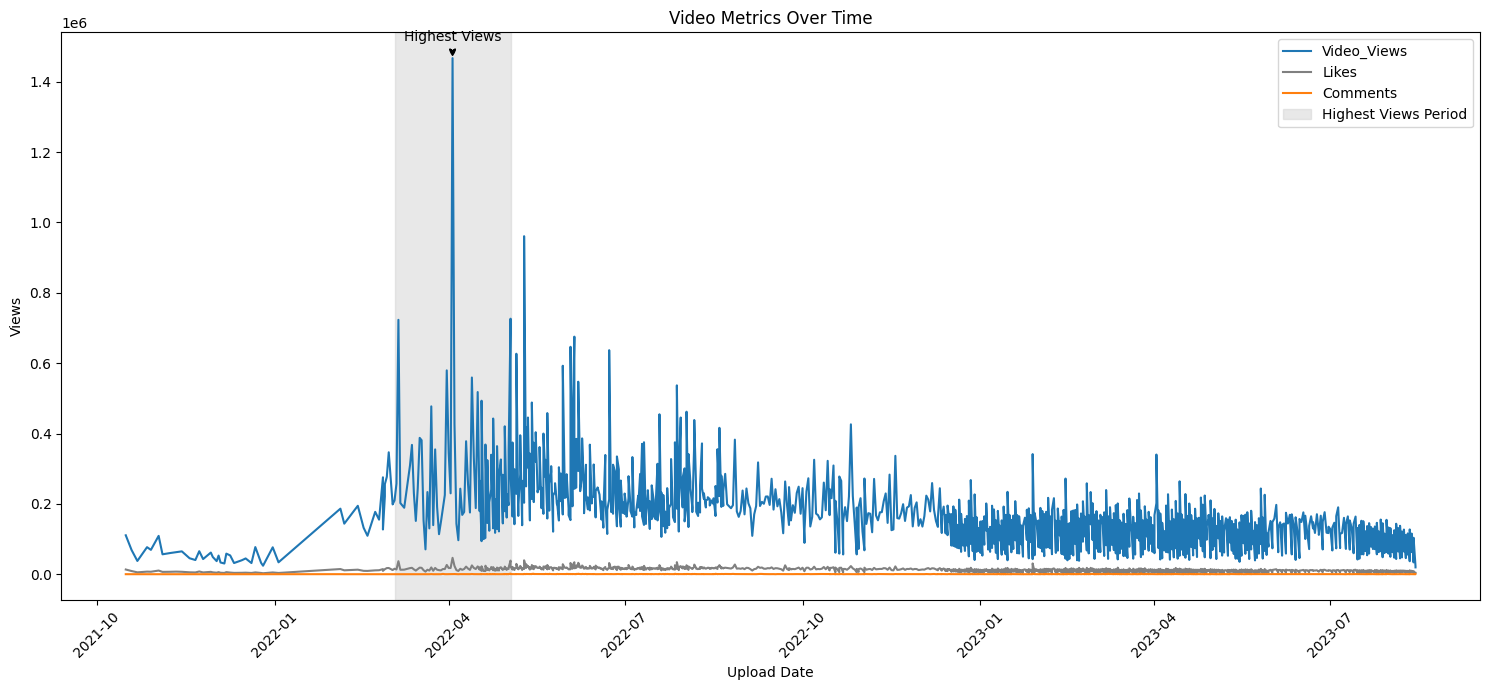

In [46]:
# Load your dataset into a Pandas DataFrame
df = pd.read_csv('video_data.csv')

# Convert Video_Published_Date to datetime
df['Video_Published_Date'] = pd.to_datetime(df['Video_Published_Date'])

# This line sets the 'Video_Published_Date' column as the index of the DataFrame. This is important for time series analysis and plotting data over time.
df.set_index('Video_Published_Date', inplace=True)


#  It returns the date (index) associated with the maximum value in the 'Video_Views' column.
max_views_date = df['Video_Views'].idxmax()


# Plot the 'Views' column over time
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Video_Views'], label='Video_Views')
plt.plot(df.index, df['Video_Likes'], label='Likes' , color = "Grey")
plt.plot(df.index, df['Video_Comments'], label='Comments')
plt.xlabel('Upload Date')
plt.ylabel('Views')
plt.title('Video Metrics Over Time')


# This code adds a shaded region around the period with the highest views, using axvspan() to highlight it.
plt.axvspan(max_views_date - pd.DateOffset(days=30), max_views_date + pd.DateOffset(days=30), color='lightgrey', alpha=0.5, label='Highest Views Period')
plt.annotate('Highest Views', xy=(max_views_date, df['Video_Views'].max()), xytext=(max_views_date, df['Video_Views'].max() + 50000),
            arrowprops=dict(facecolor='black', arrowstyle='fancy'),
            fontsize=10, ha='center', fontfamily='sans-serif')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



Which videos have the highest engagement (likes + dislikes)?   ( Insted of dislikes, we'll use comments as youtube have removed the dislike feature)

Solution: Calculate the engagement for each video and sort the DataFrame accordingly.

In [47]:
# Load the dataset
df = pd.read_csv('video_data.csv')

# Calculate total engagement (likes + comments) for each video
df['Total_Engagement'] = df['Video_Likes'] + df['Video_Comments']

# Sort the DataFrame by total engagement in descending order
sorted_df = df.sort_values(by='Total_Engagement', ascending=False)

# Print the videos with the highest engagement
top_engagement_videos = sorted_df[['Video_Title', 'Total_Engagement']].head(10)
print(top_engagement_videos)

                                           Video_Title  Total_Engagement
850  Cars Vs Cars 99.716% People Fall in Water in T...             47284
805  99.999% People Can NEVER Complete This Parkour...             40660
790  Car Vs Car 99.915% People Fall in A Hole in Th...             40609
875      Rate This Landing in GTA 5 Race #gta5 #shorts             37450
632  999.555% IMPOSSIBLE Hard Skate Board Mega Ramp...             35237
739  97.665% People Cannot Complete This IMPOSSIBLE...             34935
734  Cars Vs Cars 99.888% People Break Their Comput...             34191
742  Cars Vs Car 99.888% People Leave Their Home Af...             32940
702  Cars vs Cars 99.9999% Impossible Colourful Tun...             32488
368  Shaving My Head if i Dont Defeat Triggered Insaan             32296


4. Which tags are most commonly used in video descriptions?

Solution: Analyze the frequency of each tag and visualize the top tags.

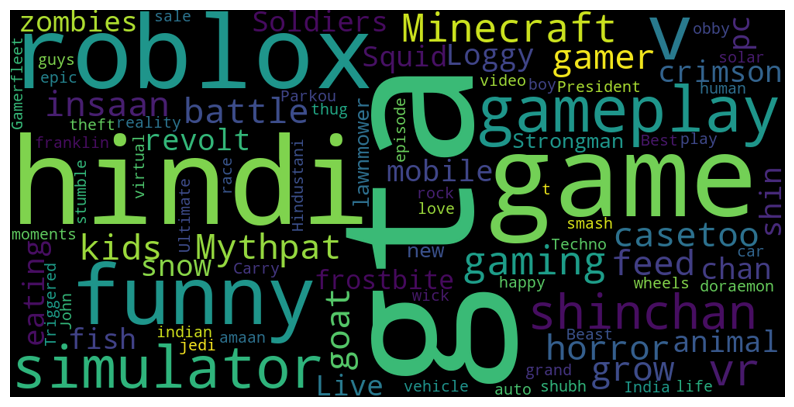

In [48]:
# Load your dataset into a Pandas DataFrame
df = pd.read_csv('video_data.csv')

# Extract and combine unique tags into a single string
all_tags = ' '.join(set([
    tag for tags in
        df['Video_Tags'] 
            for tag in 
                eval(tags)
                ]))      
# The eval(tags) part evaluates the string representation of the list into an actual list of tags.
# set function helps remove duplicate tags, ensuring that each tag appears only once.
# ' '.join(set(...)): This combines the unique tags into a single string, separated by spaces.


# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(all_tags)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='catrom')
plt.axis('off')
plt.show()

5. Are there any correlations between views, likes, and dislikes?

Solution: Calculate the correlation matrix and create a heatmap to visualize correlations.

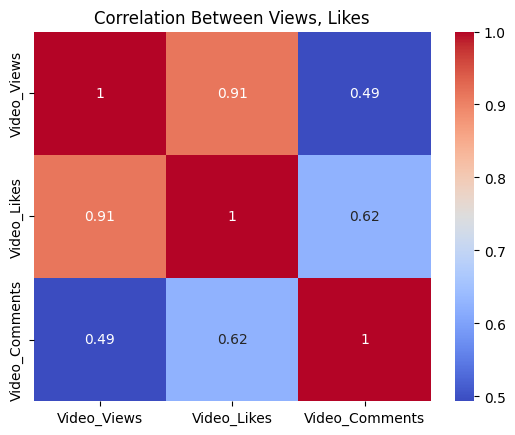

In [49]:
correlation_matrix = df[['Video_Views', 'Video_Likes', 'Video_Comments']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Views, Likes')
plt.show()

6. How has the channel's upload frequency changed over time?

Solution: Group videos by month and count the number of uploads per month.

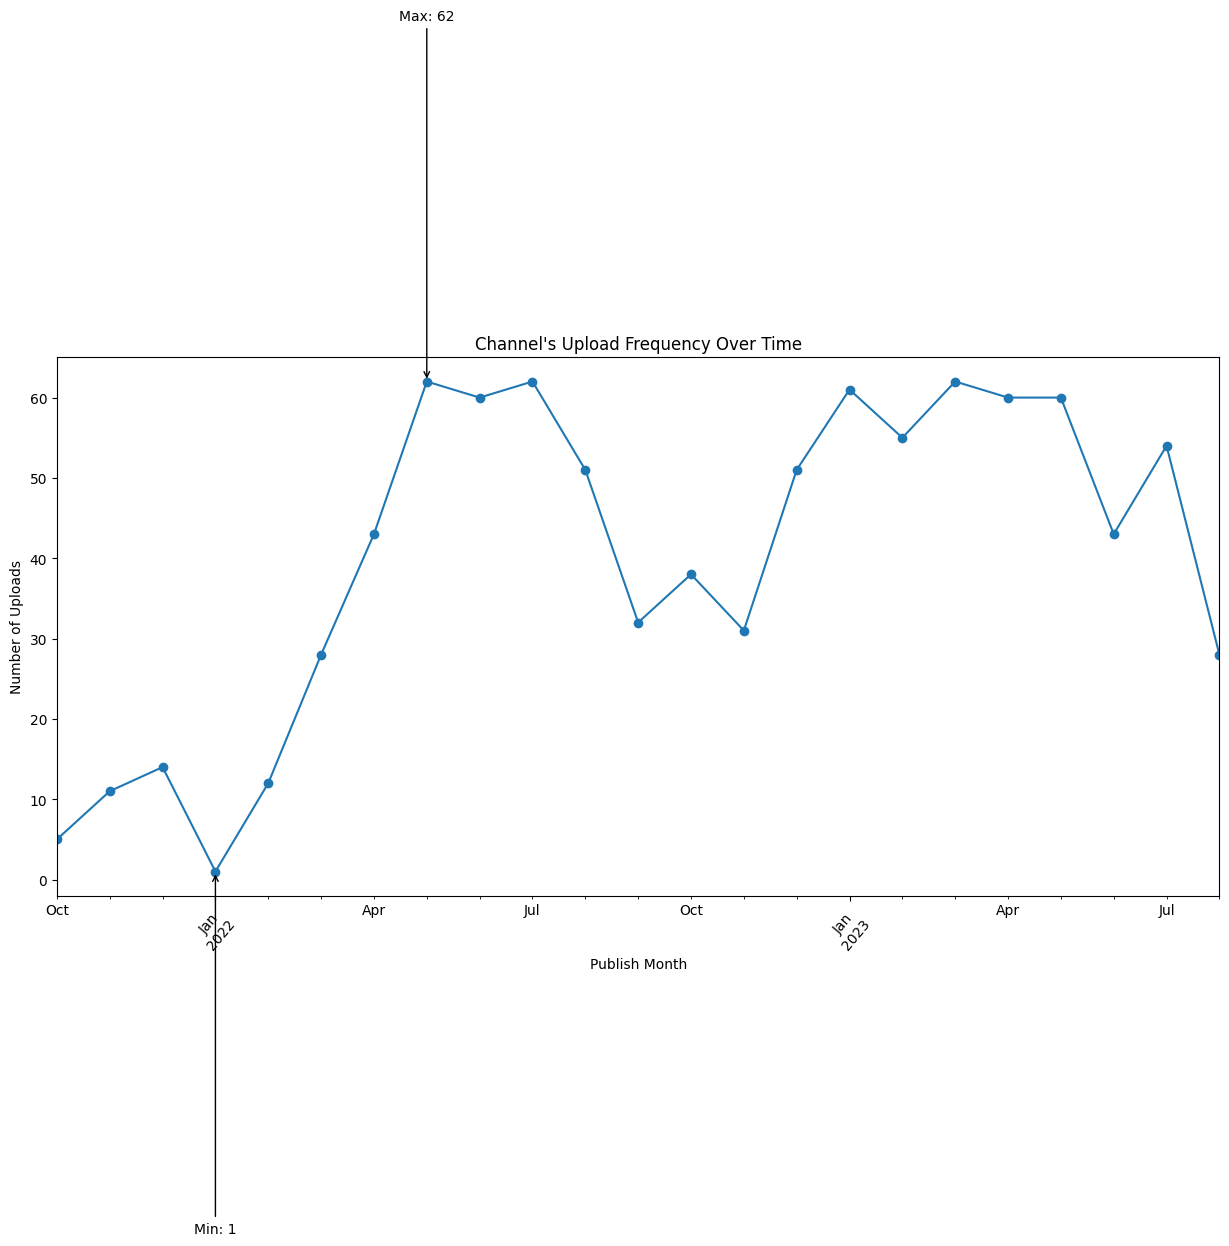

In [66]:
# Load the dataset
df = pd.read_csv('video_data.csv')

# Convert Video_Published_Date to datetime
df['Video_Published_Date'] = pd.to_datetime(df['Video_Published_Date'])

# Group videos by month and count the number of uploads per month
uploads_per_month = df.groupby(df['Video_Published_Date'].dt.to_period('M')).size()

# Plot the upload frequency over time
plt.figure(figsize=(15, 7))
uploads_per_month.plot(kind='line', marker='o')
plt.xlabel('Publish Month')
plt.ylabel('Number of Uploads')
plt.title("Channel's Upload Frequency Over Time")
plt.xticks(rotation=50)


# Find and annotate the minimum value
min_uploads = uploads_per_month.min()
min_month = uploads_per_month.idxmin().strftime('%Y-%m')  # Convert Period to string
plt.annotate(f'Min: {min_uploads}', xy=(min_month, min_uploads),
            xytext=(min_month, min_uploads - 45),  # Adjust vertical position
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10, ha='center')

# Find and annotate the maximum value
max_uploads = uploads_per_month.max()
max_month = uploads_per_month.idxmax().strftime('%Y-%m')  # Convert Period to string
plt.annotate(f'Max: {max_uploads}', xy=(max_month, max_uploads),
            xytext=(max_month, max_uploads + 45),  # Adjust vertical position
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10, ha='center')

#plt.tight_layout()
plt.show()


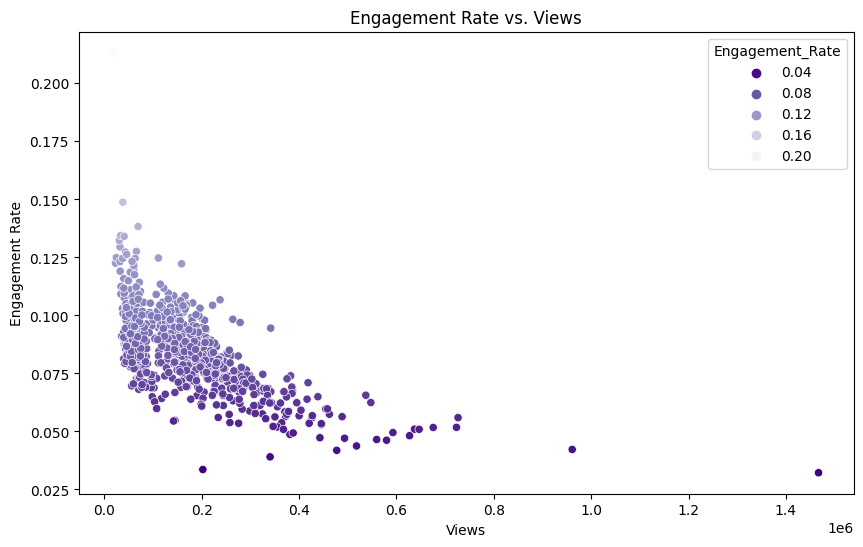

In [51]:
# Load the dataset
df = pd.read_csv('video_data.csv')

# Convert Video_Published_Date to datetime
df['Video_Published_Date'] = pd.to_datetime(df['Video_Published_Date'])

# Calculate and plot engagement rate
df['Engagement_Rate'] = (df['Video_Likes'] + df['Video_Comments']) / df['Video_Views']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Video_Views', y='Engagement_Rate' , hue = "Engagement_Rate" ,palette = 'Purples_r')
plt.xlabel('Views')
plt.ylabel('Engagement Rate')
plt.title('Engagement Rate vs. Views')
plt.show()

#### Distribution of  Video

In [52]:
average_views = df['Video_Views'].mean()
max_views = df['Video_Views'].max()
min_views = df['Video_Views'].min()
print(f"Average Views per Video: {average_views}")
print(f"Maximum Views: {max_views}")
print(f"Minimum Views: {min_views}")

Average Views per Video: 172593.03787878787
Maximum Views: 1467132
Minimum Views: 19667


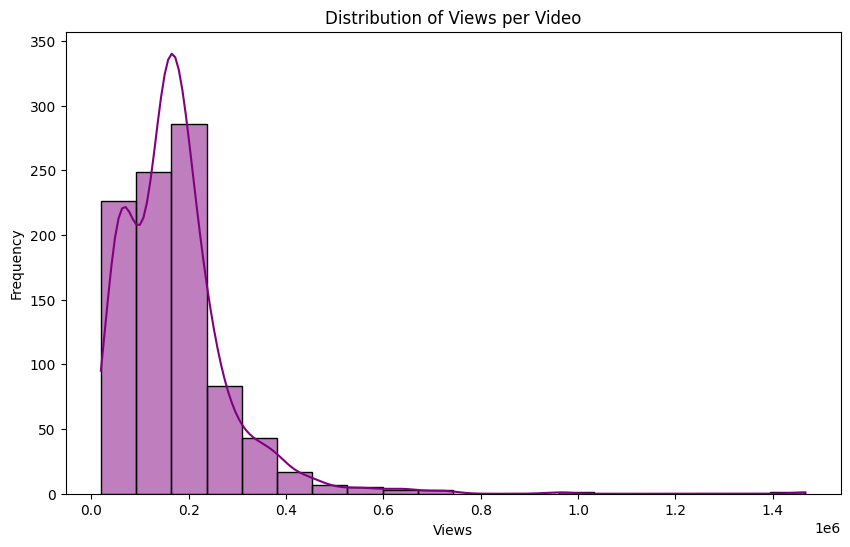

In [53]:
# Visualize Views DistributionS
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Video_Views', bins=20, kde=True , color = "Purple") 
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.title('Distribution of Views per Video')
plt.show()

#### Distribution for Likes, Comments and Views

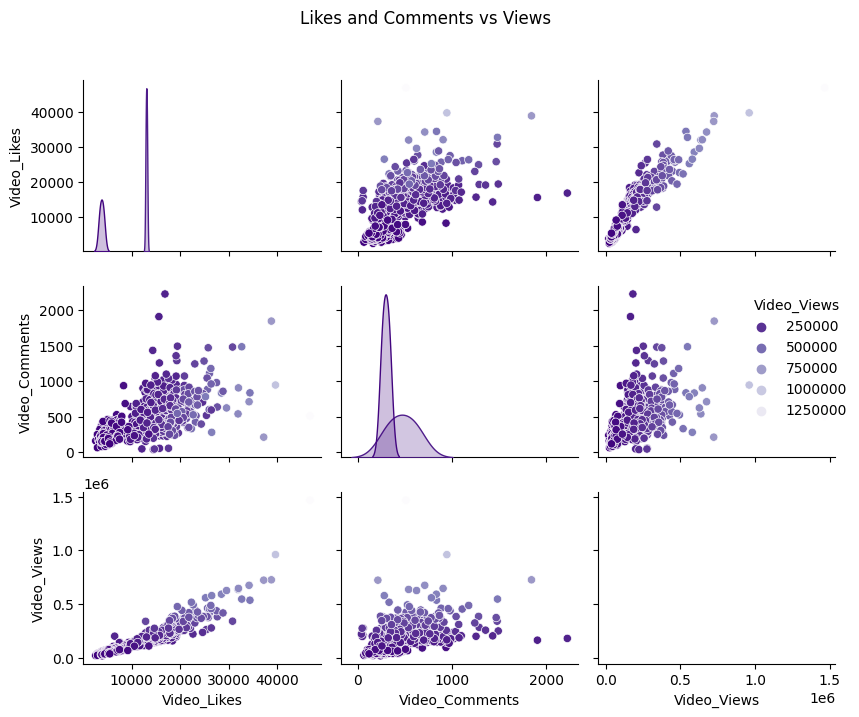

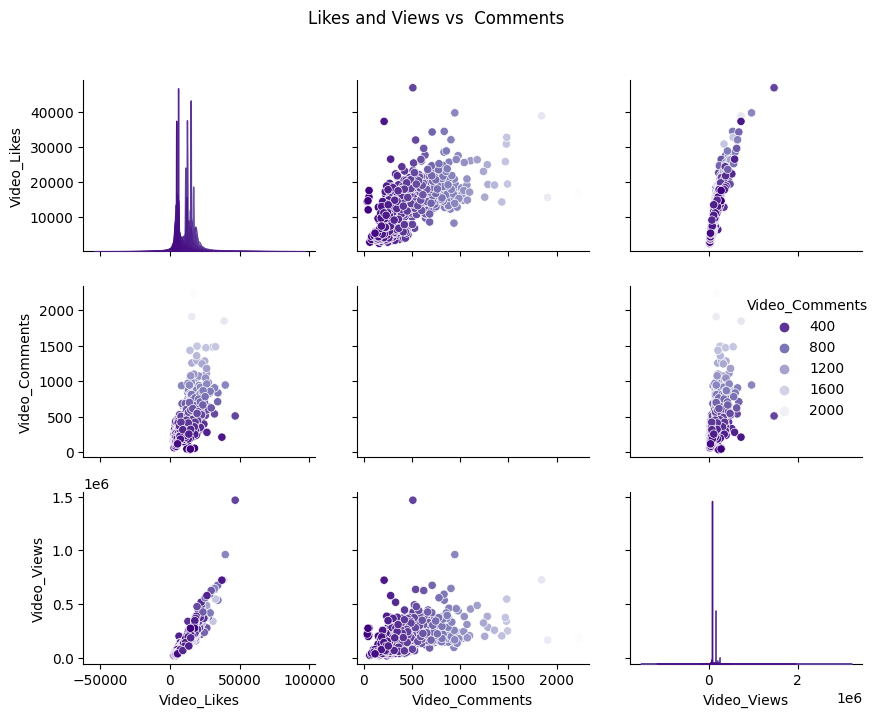

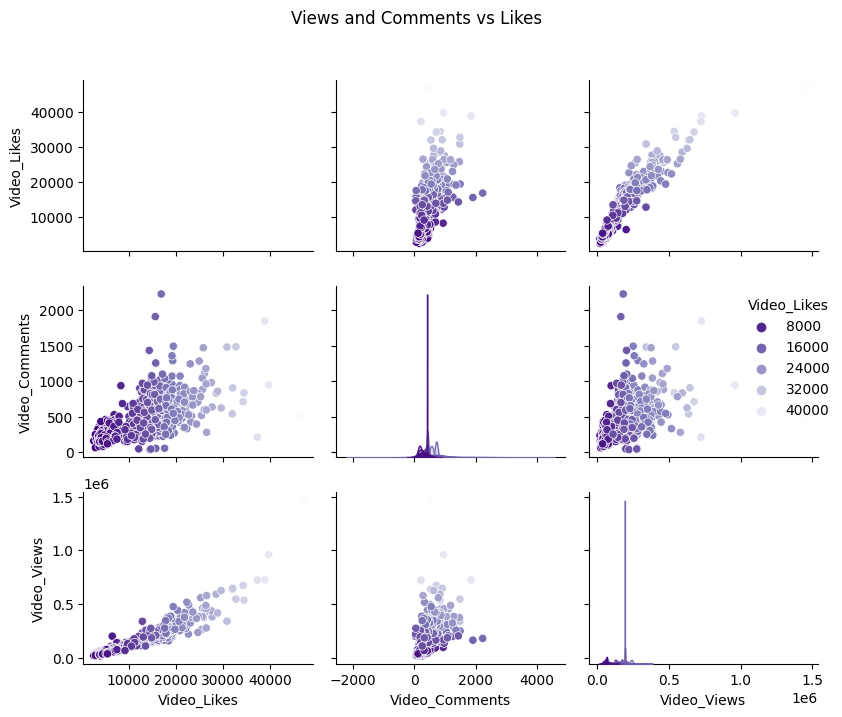

In [54]:
# Set the color Palette
# sns.set_palette("colorblind")

sns.pairplot(data=df, vars=['Video_Likes', 'Video_Comments', 'Video_Views'] ,  palette = "Purples_r" , hue = "Video_Views")  
plt.suptitle('Likes and Comments vs Views')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

sns.pairplot(data=df, vars=['Video_Likes', 'Video_Comments', 'Video_Views']  , palette = "Purples_r" , hue = "Video_Comments")  
plt.suptitle('Likes and Views vs  Comments')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

sns.pairplot(data=df, vars=['Video_Likes', 'Video_Comments', 'Video_Views'] ,  palette = "Purples_r" , hue = "Video_Likes" ) 
plt.suptitle('Views and Comments vs Likes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

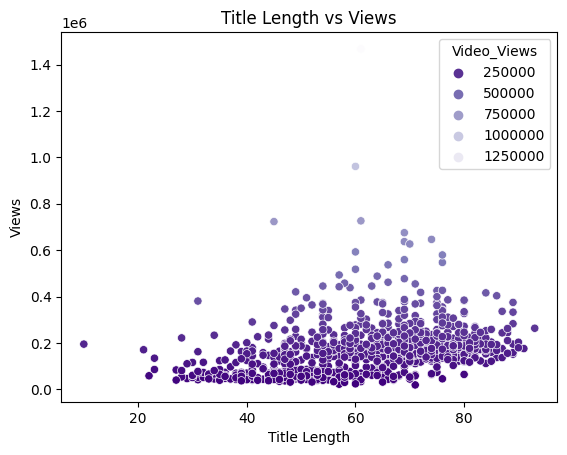

In [55]:
# Question 3: Title Length vs Views
df['Title_Length'] = df['Video_Title'].apply(len)  # Calculate title length
sns.scatterplot(data=df, x='Title_Length', y='Video_Views', palette = "Purples_r" , hue = "Video_Views")
plt.xlabel('Title Length')
plt.ylabel('Views')
plt.title('Title Length vs Views')
plt.show()

#### Video Upload Schedules

In [56]:
df['Video_Published_Date'] = pd.to_datetime(df['Video_Published_Date'])
df['DayOfWeek'] = df['Video_Published_Date'].dt.day_name()

# Calculate average Views, Likes, and Comments per day
daily_metrics = df.groupby('DayOfWeek')[['Video_Views', 'Video_Likes', 'Video_Comments']].mean()
daily_metrics

,Video_Views,Video_Likes,Video_Comments
DayOfWeek,,,
Friday,169472.666667,13027.372093,434.573643
Monday,169657.410853,12793.170543,435.852713
Saturday,176165.358209,13361.567164,469.783582
Sunday,179338.557143,13035.778571,428.671429
Thursday,169860.272059,12797.411765,410.419118
Tuesday,172250.181818,13114.098485,463.628788
Wednesday,170779.112903,12934.346774,449.758065


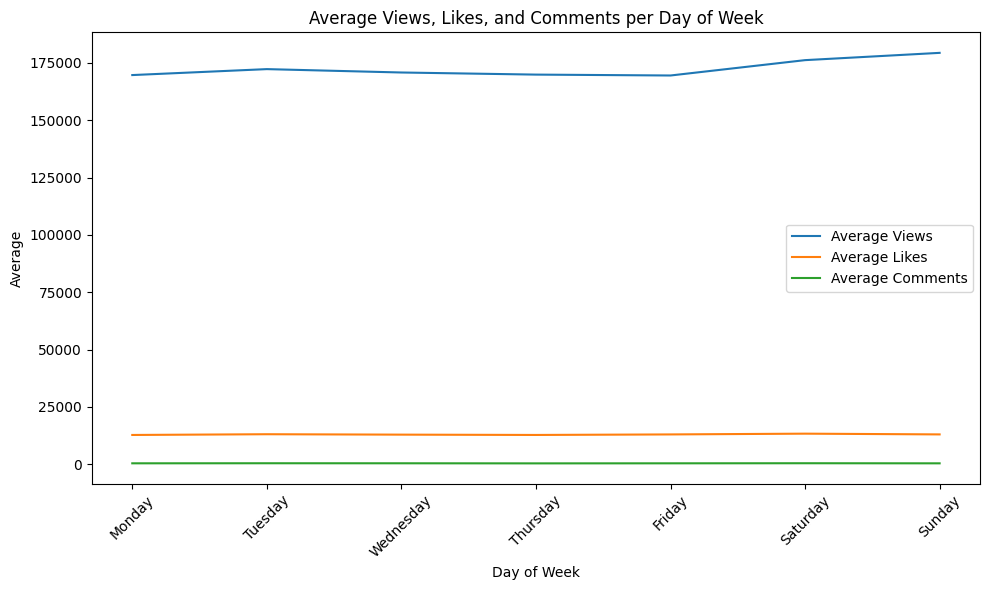

In [57]:

# Extract the day of the week from the datetime and map it to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek'] = df['Video_Published_Date'].dt.dayofweek.map(lambda x: day_names[x])

# Calculate the average values
average_values = df.groupby('DayOfWeek')[['Video_Views', 'Video_Comments', 'Video_Likes']].mean().reset_index()
average_values.rename(columns={'Video_Views': 'Average_Views', 'Video_Comments': 'Average_Comments', 'Video_Likes': 'Average_Likes'}, inplace=True)

# Set the 'DayOfWeek' column as a categorical variable with custom order
average_values['DayOfWeek'] = pd.Categorical(average_values['DayOfWeek'], categories=day_names, ordered=True)

# Sort the DataFrame by the custom order
average_values = average_values.sort_values('DayOfWeek')

# Visualize using area chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_values, x='DayOfWeek', y='Average_Views', label='Average Views')
sns.lineplot(data=average_values, x='DayOfWeek', y='Average_Likes', label='Average Likes')
sns.lineplot(data=average_values, x='DayOfWeek', y='Average_Comments', label='Average Comments')
plt.xlabel('Day of Week')
plt.ylabel('Average')
plt.title('Average Views, Likes, and Comments per Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()



##### We can see that Avg likes and comments are similar accross weekdays, but after friday, we can see there are sudden changes in number of views. It can tell usa about the subscribers behaviour's as they might have time on Sundays to watch the video 

### Video Description 

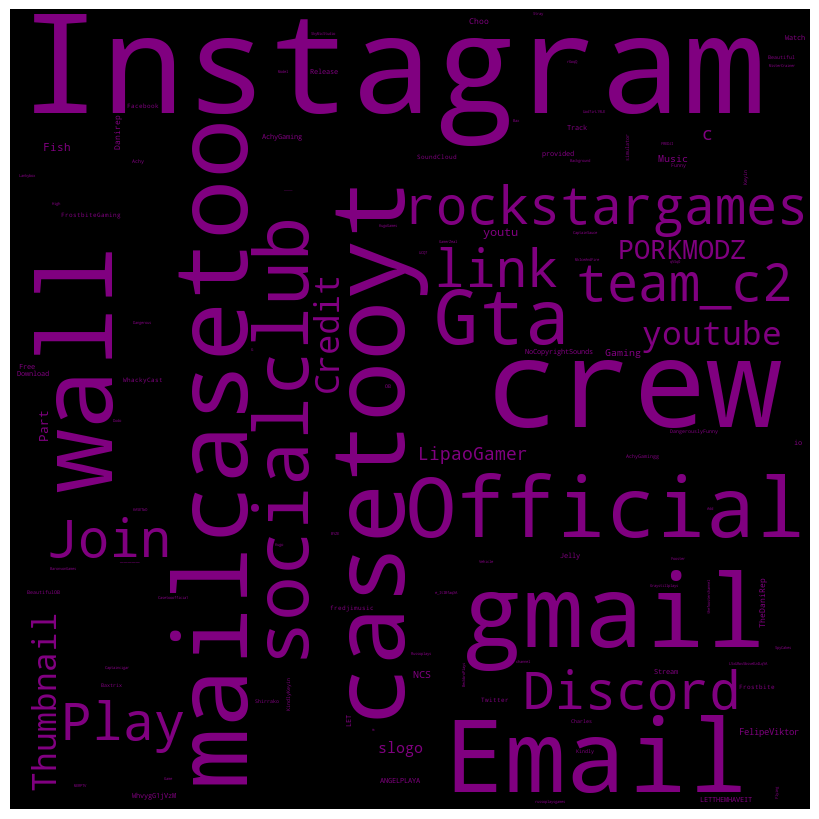

In [58]:

# Load the dataset
df = pd.read_csv('video_data.csv')

# Concatenate all video descriptions into a single text
all_descriptions = ' '.join(df['Video_Description'])

# Remove 'https' from the text
all_descriptions = all_descriptions.replace('https', '')

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='black', colormap='viridis', collocations=False).generate(all_descriptions)

# # Define a color function for the word cloud
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'rgb(128, 0, 128)'  # White color for the words

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud.recolor(color_func=black_color_func), interpolation='bicubic')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


#### Video's uploaded in each month

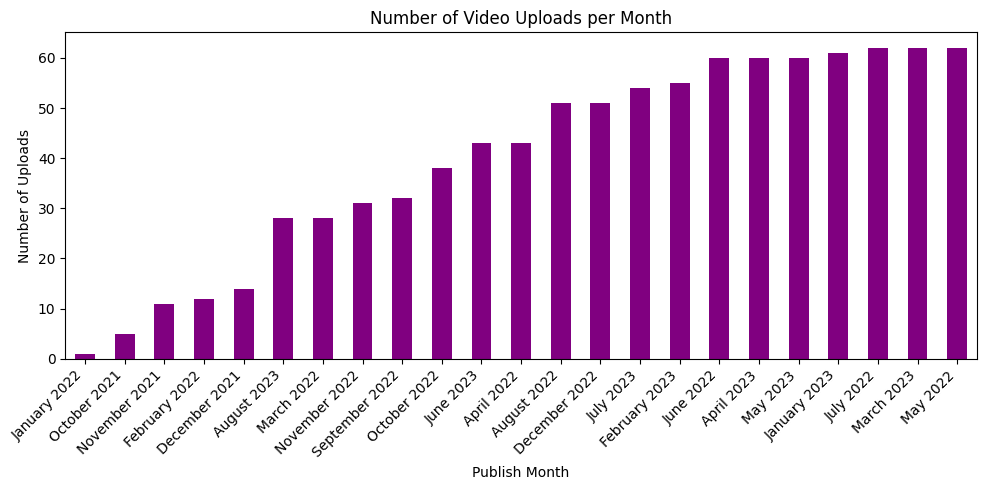

Video_Published_Date
2022-01     1
2021-10     5
2021-11    11
2022-02    12
2021-12    14
2023-08    28
2022-03    28
2022-11    31
2022-09    32
2022-10    38
2023-06    43
2022-04    43
2022-08    51
2022-12    51
2023-07    54
2023-02    55
2022-06    60
2023-04    60
2023-05    60
2023-01    61
2022-07    62
2023-03    62
2022-05    62
Freq: M, dtype: int64

In [59]:
# Load the dataset
df = pd.read_csv('video_data.csv')

# Convert 'Video_Published_Date' to datetime format
df['Video_Published_Date'] = pd.to_datetime(df['Video_Published_Date'])

# Group videos by month and count the number of uploads per month
uploads_per_month = df.groupby(df['Video_Published_Date'].dt.to_period('M')).size()

# Sort the values in ascending order
uploads_per_month_sorted = uploads_per_month.sort_values()

# Plot the upload frequency over time as a bar chart
plt.figure(figsize=(10, 5))
ax = uploads_per_month_sorted.plot(kind='bar', color='purple')
ax.set_xlabel('Publish Month')
ax.set_ylabel('Number of Uploads')
ax.set_title("Number of Video Uploads per Month")
plt.xticks(range(len(uploads_per_month_sorted)),
        [month.strftime('%B %Y') for month in uploads_per_month_sorted.index.to_timestamp()],
        rotation=45, ha='right')

plt.tight_layout()
plt.show()
uploads_per_month_sorted


### Views in each Month

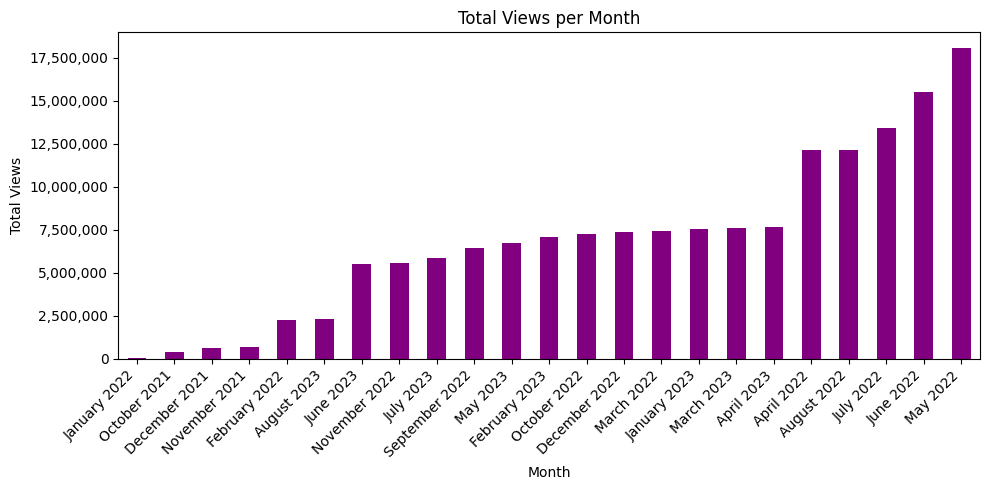

In [60]:
# Load the dataset
df = pd.read_csv('video_data.csv')

# Convert 'Video_Published_Date' to datetime format
df['Video_Published_Date'] = pd.to_datetime(df['Video_Published_Date'])

# Group videos by month and sum up the total views per month
views_per_month = df.groupby(df['Video_Published_Date'].dt.to_period('M'))['Video_Views'].sum()

# Sort the values in ascending order
views_per_month_sorted = views_per_month.sort_values()

# Plot the views per month
plt.figure(figsize=(10, 5))
ax = views_per_month_sorted.plot(kind='bar', color='purple')
ax.set_xlabel('Month')
ax.set_ylabel('Total Views')
ax.set_title("Total Views per Month")
plt.xticks(range(len(views_per_month_sorted)),
        [month.strftime('%B %Y') for month in views_per_month_sorted.index.to_timestamp()],
        rotation=45, ha='right')

# Format y-axis labels as integers
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))



plt.tight_layout()
plt.show()


#### From the above 2 charts, we can conclude that in March 2023, the number of videos uploaded are more than 60, but the views count are around 7.5M .

#### Most Viewed Video Comments Analysis

In [61]:
# Download NLTK stopwords and punkt data
nltk.download('stopwords', quiet=True)
nltk.download('punkt')

# Function to get the title of the most viewed video
def get_most_viewed_video(youtube, **kwargs):
    response = youtube.videos().list(**kwargs).execute()
    most_viewed_video = response['items'][0]['snippet']['title']
    return most_viewed_video

# Specify the video ID of the most viewed video
most_viewed_video_id = "64OCJpl6QAc"

# Get the title of the most viewed video
most_viewed_video_title = get_most_viewed_video(youtube, part="snippet", id=most_viewed_video_id)

# Specify the video ID of the top-performing video
video_id = "64OCJpl6QAc"

# Get the comments from the video
def get_video_comments(youtube, **kwargs):
    comments = []
    results = youtube.commentThreads().list(**kwargs).execute()
    
    while results:
        for item in results["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)
        if "nextPageToken" in results:
            kwargs["pageToken"] = results["nextPageToken"]
            results = youtube.commentThreads().list(**kwargs).execute()
        else:
            break
    
    return comments

# Function to get additional information about the video
def get_video_details(youtube, **kwargs):
    response = youtube.videos().list(**kwargs).execute()
    video_details = {
        "description": response['items'][0]['snippet']['description'],
        # "tags": response['items'][0]['snippet']['tags'],
        "likes": response['items'][0]['statistics']['likeCount'],
        "comments": response['items'][0]['statistics']['commentCount']
    }
    return video_details

# Get additional information about the most viewed video
most_viewed_video_details = get_video_details(youtube, part="snippet,statistics", id=most_viewed_video_id)

# Print the additional information
print("Most Viewed Video Details:")
print("Description:", most_viewed_video_details["description"])
#print("Tags:", most_viewed_video_details["tags"])
print("Likes:", most_viewed_video_details["likes"])
print("Comments:", most_viewed_video_details["comments"])


# Perform sentiment analysis using TextBlob
def analyze_sentiment(comments):
    positive_count = 0
    neutral_count = 0
    negative_count = 0
    
    for comment in comments:
        analysis = TextBlob(comment)
        sentiment = analysis.sentiment.polarity
        if sentiment > 0:
            positive_count += 1
        elif sentiment == 0:
            neutral_count += 1
        else:
            negative_count += 1
    
    total_comments = len(comments)
    sentiment_analysis = {
        "Positive": positive_count / total_comments,
        "Neutral": neutral_count / total_comments,
        "Negative": negative_count / total_comments
    }

    return sentiment_analysis

# Perform keyword extraction using NLTK
def analyze_keywords(comments):
    stop_words = set(stopwords.words("english"))
    keywords = Counter()
    
    for comment in comments:
        words = word_tokenize(comment)
        words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        keywords.update(words)
    return keywords.most_common(20)  # Get the top 20 keywords

# Preprocess comments to remove URLs
def preprocess_comments(comments):
    processed_comments = []
    for comment in comments:
        # Remove URLs using a regular expression
        processed_comment = re.sub(r'http\S+', 'TimeStamp', comment)
        processed_comments.append(processed_comment)
    return processed_comments

# Fetch and analyze comments
if __name__ == "__main__":
    comments = get_video_comments(youtube, part="snippet", videoId=video_id, textFormat="plainText")

    # Process comments to remove URLs
    processed_comments = [re.sub(r'http\S+', 'TimeStamp', comment) for comment in comments]
    
    sentiment_analysis = analyze_sentiment(processed_comments)
    print("Sentiment Analysis:", sentiment_analysis)
    
    top_keywords = analyze_keywords(processed_comments)
    print("Top Keywords:", top_keywords)
    
    print("Most Viewed Video Title:", most_viewed_video_title)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chirag.a.tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Most Viewed Video Details:
Description: Join the crew to Play Gta 5 With me
Discord link is in The crew Wall - 
https://socialclub.rockstargames.com/crew/team_c2/wall

Official Instagram - https://Instagram.com/casetooyt

Email - mailcasetoo@gmail.com
Likes: 46773
Comments: 511
Sentiment Analysis: {'Positive': 0.19114219114219114, 'Neutral': 0.7365967365967366, 'Negative': 0.07226107226107226}
Top Keywords: [('bhai', 69), ('casetoo', 42), ('bro', 33), ('video', 31), ('ki', 26), ('timestamp', 25), ('hai', 25), ('se', 25), ('race', 21), ('ka', 19), ('game', 19), ('bhi', 18), ('love', 18), ('ke', 16), ('videos', 15), ('gta', 14), ('h', 13), ('hi', 13), ('face', 13), ('raha', 12)]
Most Viewed Video Title: Cars Vs Cars 99.716% People Fall in Water in This GTA 5 RACE!


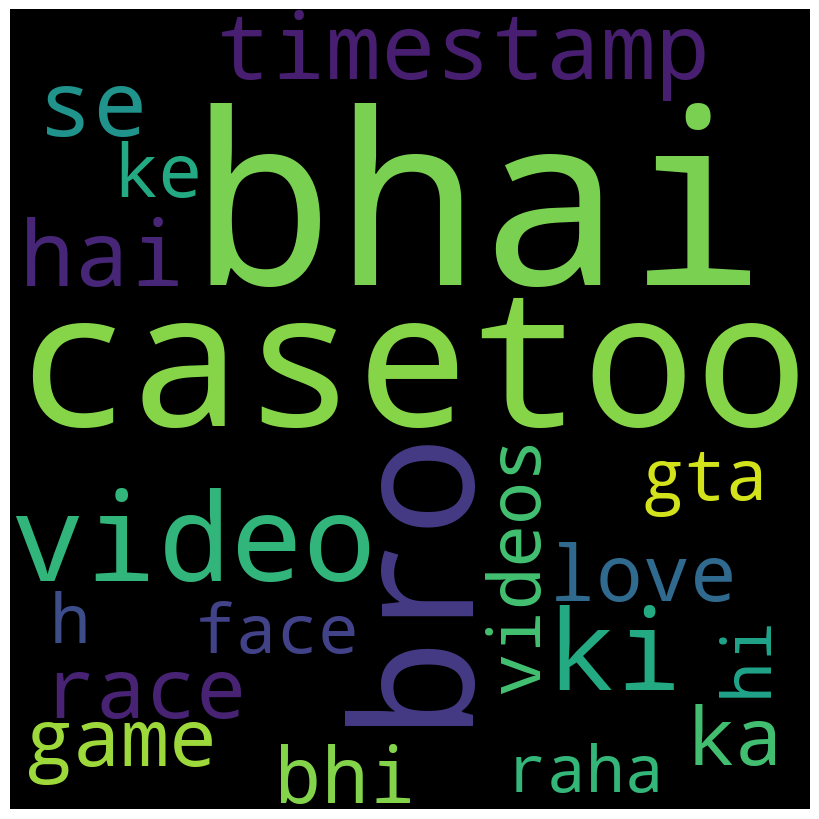

In [62]:
# WordCloud Visual of above plot
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud instance
wordcloud = WordCloud(width=800, height=800, background_color='black', max_words=20).generate_from_frequencies(dict(top_keywords))

# Display the WordCloud image using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the WordCloud as an image
wordcloud.to_file("wordcloud.png")

# Show the WordCloud
plt.show()
